In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.applications import InceptionV3, EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.inception_v3 import decode_predictions
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Conv2D
from keras.layers import Reshape
from keras.layers import Flatten

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
main_folder = "/kaggle/input/finalsites/site"

In [3]:
# Function to load and preprocess images
def load_and_preprocess_data(output_folder):
    data_inception = []
    data_efficientnet = []
    data_resnet = []
    data_vgg = []
    labels = []

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for label, folder in enumerate(os.listdir(main_folder)):
        folder_path = os.path.join(main_folder, folder)
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)

            # Load and preprocess image for InceptionV3
            img_inception = load_img(img_path, target_size=(299, 299))
            img_array_inception = img_to_array(img_inception)
            
            # Apply data augmentation
            img_array_inception = datagen.random_transform(img_array_inception)
            
            img_array_inception = preprocess_inception(img_array_inception)
            data_inception.append(img_array_inception)

            # Load and preprocess image for EfficientNet
            img_efficientnet = load_img(img_path, target_size=(224, 224))
            img_array_efficientnet = img_to_array(img_efficientnet)
            
            # Apply data augmentation
            img_array_efficientnet = datagen.random_transform(img_array_efficientnet)
            
            img_array_efficientnet = preprocess_efficientnet(img_array_efficientnet)
            data_efficientnet.append(img_array_efficientnet)

            # Load and preprocess image for ResNet
            img_resnet = load_img(img_path, target_size=(224, 224))
            img_array_resnet = img_to_array(img_resnet)
            
            # Apply data augmentation
            img_array_resnet = datagen.random_transform(img_array_resnet)
            
            img_array_resnet = preprocess_resnet(img_array_resnet)
            data_resnet.append(img_array_resnet)

            # Load and preprocess image for VGGNet
            img_vgg = load_img(img_path, target_size=(224, 224))
            img_array_vgg = img_to_array(img_vgg)
            
            # Apply data augmentation
            img_array_vgg = datagen.random_transform(img_array_vgg)
            
            img_array_vgg = preprocess_vgg(img_array_vgg)
            data_vgg.append(img_array_vgg)

            labels.append(label)

    return {
        "inception": np.array(data_inception),
        "efficientnet": np.array(data_efficientnet),
        "resnet": np.array(data_resnet),
        "vgg": np.array(data_vgg),
    }, np.array(labels)

In [4]:
# Call the function
data, labels = load_and_preprocess_data(main_folder)

In [5]:
label_to_site = {labels: site for labels, site in enumerate(os.listdir(main_folder))}
np.unique(labels)
labels_encoded = to_categorical(labels)

In [6]:
label_to_site

{0: 'Roman_amphitheater',
 1: 'Petra',
 2: 'Umm_Qais',
 3: 'Jerash',
 4: 'WadiRum',
 5: 'Ajloun'}

In [7]:
#InceptionV3_train_test_split
# Assuming you have X_train, X_test, y_train, and y_test
X_train, X_test, y_train, y_test = train_test_split(data['inception'], labels_encoded, test_size=0.2, random_state=42)

In [8]:
# Load the InceptionV3 model with pre-trained weights on ImageNet
InceptionV3_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87910968/87910968 [==============================] - 4s 0us/step


In [9]:
# Freeze the layers of the base model
for layer in InceptionV3_base_model.layers:
    layer.trainable = False

In [10]:
x = InceptionV3_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(600, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

predictions = Dense(len(label_to_site), activation='softmax')(x)

# Create the fine-tuned model
InceptionV3_fine_tuned_model = Model(inputs=InceptionV3_base_model.input, outputs=predictions)

# Compile the model with the correct learning rate argument
InceptionV3_fine_tuned_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create the early stopping callback
early_stopping_InceptionV3 = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [11]:
# Train the model with early stopping
InceptionV3_fine_tuned_model.fit(X_train, y_train, 
                     epochs=15, batch_size=32, 
                     validation_data=(X_test, y_test), 
                     callbacks=[early_stopping_InceptionV3])

Epoch 1/15
86/86 [==============================] - 397s 5s/step - loss: 2.0243 - accuracy: 0.5590 - val_loss: 1.4652 - val_accuracy: 0.7263
Epoch 2/15
86/86 [==============================] - 385s 4s/step - loss: 1.3417 - accuracy: 0.7309 - val_loss: 1.2492 - val_accuracy: 0.7453
Epoch 3/15
86/86 [==============================] - 383s 4s/step - loss: 1.1192 - accuracy: 0.7739 - val_loss: 1.1253 - val_accuracy: 0.7642
Epoch 4/15
86/86 [==============================] - 383s 4s/step - loss: 0.9705 - accuracy: 0.7953 - val_loss: 1.0147 - val_accuracy: 0.7817
Epoch 5/15
86/86 [==============================] - 380s 4s/step - loss: 0.8906 - accuracy: 0.7953 - val_loss: 0.9951 - val_accuracy: 0.7598
Epoch 6/15
86/86 [==============================] - 385s 4s/step - loss: 0.8083 - accuracy: 0.8237 - val_loss: 0.8859 - val_accuracy: 0.7889
Epoch 7/15
86/86 [==============================] - 386s 5s/step - loss: 0.7642 - accuracy: 0.8274 - val_loss: 0.8980 - val_accuracy: 0.7729


In [12]:
InceptionV3_losses = pd.DataFrame(InceptionV3_fine_tuned_model.history.history)
InceptionV3_losses

,loss,accuracy,val_loss,val_accuracy
0,2.024338,0.558995,1.465192,0.726346
1,1.341706,0.730881,1.249179,0.745269
2,1.119160,0.773853,1.125344,0.764192
3,0.970480,0.795339,1.014664,0.781659
4,0.890616,0.795339,0.995145,0.759825
5,0.808303,0.823744,0.885857,0.788937
6,0.764200,0.827385,0.898034,0.772926


<Axes: >

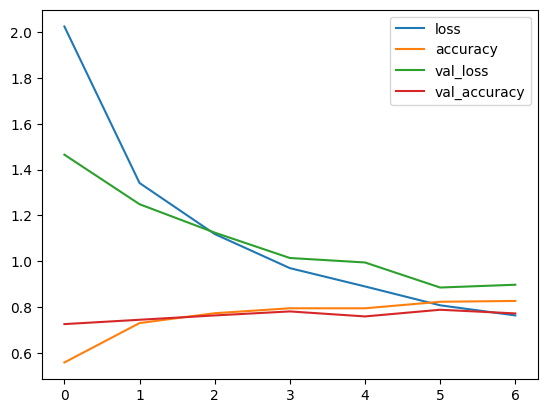

In [13]:
InceptionV3_losses.plot()

In [16]:
pred = InceptionV3_fine_tuned_model.predict(X_test)

22/22 [==============================] - 78s 3s/step


In [17]:
y_test[0] , pred[0]

(array([0., 0., 0., 0., 1., 0.], dtype=float32),
 array([6.0516468e-04, 3.8826555e-02, 3.9353981e-03, 1.3741995e-03,
        9.0561050e-01, 4.9648225e-02], dtype=float32))

In [18]:
post =np.where(pred >= 0.5, 1,0)

In [20]:
pred[0], post[0], y_test[0]

(array([6.0516468e-04, 3.8826555e-02, 3.9353981e-03, 1.3741995e-03,
        9.0561050e-01, 4.9648225e-02], dtype=float32),
 array([0, 0, 0, 0, 1, 0]),
 array([0., 0., 0., 0., 1., 0.], dtype=float32))

In [21]:
pred.min(),pred.max(), pred.mean()

(3.3925577e-08, 0.9995864, 0.16666667)

In [22]:
#classification_report for Inception model
print(classification_report(y_test, post))

              precision    recall  f1-score   support

           0       0.92      0.68      0.78       122
           1       0.77      0.83      0.80       157
           2       0.85      0.62      0.72        94
           3       0.74      0.83      0.78        82
           4       0.88      0.70      0.78       128
           5       0.87      0.76      0.81       104

   micro avg       0.83      0.74      0.78       687
   macro avg       0.84      0.74      0.78       687
weighted avg       0.84      0.74      0.78       687
 samples avg       0.74      0.74      0.74       687



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Save the weights to an H5 file
InceptionV3_fine_tuned_model.save('Final_Inception_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
#Efficientnet_Model_train_test_split
from sklearn.model_selection import train_test_split
# Assuming you have X_train, X_test, y_train, and y_test
X_train, X_test, y_train, y_test = train_test_split(data['efficientnet'], labels_encoded, test_size=0.2, random_state=42)

In [25]:
# Load the InceptionV3 model with pre-trained weights on ImageNet
Efficientnet_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in Efficientnet_base_model.layers:
    layer.trainable = False


16705208/16705208 [==============================] - 1s 0us/step


In [26]:
# Add your custom classification layers on top
x = Efficientnet_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(500, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_to_site), activation='softmax')(x)

# Create the fine-tuned model
fine_tuned_efficientnet_model = Model(inputs=Efficientnet_base_model.input, outputs=predictions)

# Compile the model
fine_tuned_efficientnet_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create the early stopping callback
Efficientnet_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [27]:
# Train the model with early stopping
fine_tuned_efficientnet_model.fit(X_train, y_train, 
                     epochs=10, batch_size=32, 
                     validation_data=(X_test, y_test), 
                     callbacks=[Efficientnet_early_stopping])

Epoch 1/10
86/86 [==============================] - 172s 2s/step - loss: 1.5058 - accuracy: 0.6843 - val_loss: 1.1791 - val_accuracy: 0.7802
Epoch 2/10
86/86 [==============================] - 151s 2s/step - loss: 1.0191 - accuracy: 0.8332 - val_loss: 1.0407 - val_accuracy: 0.7918
Epoch 3/10
86/86 [==============================] - 154s 2s/step - loss: 0.8555 - accuracy: 0.8700 - val_loss: 0.9892 - val_accuracy: 0.7962
Epoch 4/10
86/86 [==============================] - 151s 2s/step - loss: 0.7590 - accuracy: 0.8842 - val_loss: 0.8429 - val_accuracy: 0.8370
Epoch 5/10
86/86 [==============================] - 154s 2s/step - loss: 0.6598 - accuracy: 0.9013 - val_loss: 0.8038 - val_accuracy: 0.8341
Epoch 6/10
86/86 [==============================] - 154s 2s/step - loss: 0.5924 - accuracy: 0.9144 - val_loss: 0.7584 - val_accuracy: 0.8355
Epoch 7/10
86/86 [==============================] - 138s 2s/step - loss: 0.5558 - accuracy: 0.9155 - val_loss: 0.7465 - val_accuracy: 0.8515
Epoch 8/10
86

1/1 [==============================] - 0s 20ms/step
Predicted Class: Ajloun


In [28]:
losses_efficientnet_model = pd.DataFrame(fine_tuned_efficientnet_model.history.history)
losses_efficientnet_model

,loss,accuracy,val_loss,val_accuracy
0,1.505804,0.684268,1.179052,0.780204
1,1.019103,0.833212,1.040722,0.791849
2,0.855465,0.869993,0.989180,0.796215
3,0.758974,0.884195,0.842856,0.836972
4,0.659762,0.901311,0.803838,0.834061
5,0.592404,0.914421,0.758361,0.835517
6,0.555823,0.915513,0.746480,0.851528
7,0.516503,0.930444,0.725983,0.850073
8,0.514859,0.921340,0.762736,0.832606
9,0.496559,0.924618,0.727610,0.831150


<Axes: >

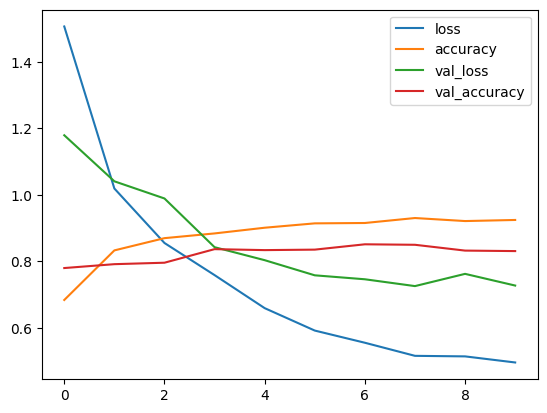

In [29]:
losses_efficientnet_model.plot()

In [30]:
efficientnet_pred = fine_tuned_efficientnet_model.predict(X_test)

22/22 [==============================] - 31s 1s/step


In [36]:
efficientnet_post =np.where(efficientnet_pred >= 0.5, 1,0)

In [38]:
#classification_report for efficientnet model
print(classification_report(y_test, efficientnet_post))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83       122
           1       0.81      0.90      0.85       157
           2       0.82      0.73      0.78        94
           3       0.94      0.80      0.87        82
           4       0.90      0.73      0.81       128
           5       0.81      0.94      0.87       104

   micro avg       0.86      0.82      0.84       687
   macro avg       0.87      0.81      0.83       687
weighted avg       0.86      0.82      0.83       687
 samples avg       0.82      0.82      0.82       687



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# Save to H5 file
fine_tuned_efficientnet_model.save('Final_efficientnet_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
#ResNet_Model_train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['resnet'], labels_encoded, test_size=0.2, random_state=42)

In [40]:
# Load the ResNet model with pre-trained weights on ImageNet
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in resnet_base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 4s 0us/step


In [41]:
x = resnet_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) 

resnet_predictions = Dense(len(label_to_site), activation='softmax')(x)

# Create the fine-tuned model
fine_tuned_resnet_model = Model(inputs=resnet_base_model.input, outputs=resnet_predictions)

# compile the model
fine_tuned_resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Create the early stopping callback
resnet_early_stopping = EarlyStopping(monitor='val_loss', patience=1,verbose=1,restore_best_weights=True)


In [47]:
# Train the model with early stopping
fine_tuned_resnet_model.fit(X_train, y_train, 
                     epochs=10, batch_size=32, 
                     validation_data=(X_test, y_test), 
                     callbacks=[resnet_early_stopping])

Epoch 1/10
86/86 [==============================] - 344s 4s/step - loss: 0.5889 - accuracy: 0.7972 - val_loss: 0.5262 - val_accuracy: 0.8079
Epoch 2/10
86/86 [==============================] - 322s 4s/step - loss: 0.3183 - accuracy: 0.8944 - val_loss: 0.5430 - val_accuracy: 0.8195
Epoch 2: early stopping


In [48]:
resnet_losses_model = pd.DataFrame(fine_tuned_resnet_model.history.history)
resnet_losses_model

,loss,accuracy,val_loss,val_accuracy
0,0.588945,0.797159,0.52621,0.807860
1,0.318271,0.894392,0.54301,0.819505


<Axes: >

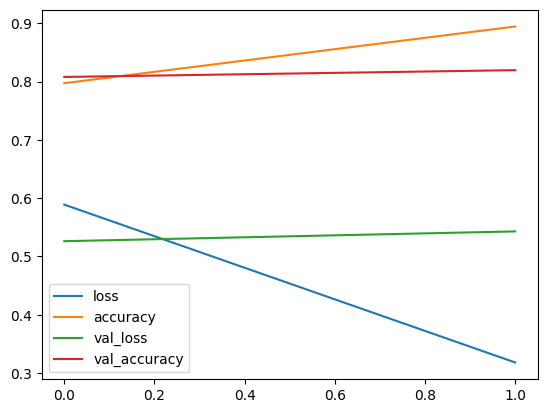

In [49]:
resnet_losses_model.plot()

In [50]:
resnet_pred = fine_tuned_resnet_model.predict(X_test)

22/22 [==============================] - 66s 3s/step


In [51]:
resnet_post =np.where(resnet_pred >= 0.5, 1,0)

In [52]:
#classification_report for resnet model
print(classification_report(y_test, resnet_post))

              precision    recall  f1-score   support

           0       0.90      0.64      0.75       122
           1       0.93      0.69      0.80       157
           2       0.78      0.77      0.77        94
           3       0.90      0.90      0.90        82
           4       0.79      0.86      0.82       128
           5       0.79      0.82      0.81       104

   micro avg       0.85      0.77      0.81       687
   macro avg       0.85      0.78      0.81       687
weighted avg       0.85      0.77      0.80       687
 samples avg       0.77      0.77      0.77       687



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
#vgg_Model_train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['vgg'], labels_encoded, test_size=0.2, random_state=42)

In [8]:
# Load the vgg model with pre-trained weights on ImageNet
vgg_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in vgg_base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [19]:
from keras.layers import MaxPooling2D, Dense, Dropout, Conv2D
from keras import regularizers

# Conv2D layers before Dense layers
x = vgg_base_model.output
#x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
#x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
#x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Flatten()(x) 
x = Dense(556, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x) 
#x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
#x = Dropout(0.5)(x) 
#x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)

# Output layer with softmax activation for multiclass categorical task
vgg_predictions = Dense(len(label_to_site), activation='softmax')(x)

# Create the fine-tuned VGG model
fine_tuned_vgg_model = Model(inputs=vgg_base_model.input, outputs=vgg_predictions)

# Compile the model
fine_tuned_vgg_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#fine_tuned_vgg_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create the early stopping callback
vgg_early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [20]:
# Train the model with early stopping
fine_tuned_vgg_model.fit(X_train, y_train, 
                         epochs=30, batch_size=32, 
                         validation_data=(X_test, y_test), 
                         callbacks=[vgg_early_stopping])

Epoch 1/30
86/86 [==============================] - 18s 186ms/step - loss: 14.6720 - accuracy: 0.4811 - val_loss: 9.0844 - val_accuracy: 0.6172
Epoch 2/30
86/86 [==============================] - 15s 177ms/step - loss: 7.6638 - accuracy: 0.7873 - val_loss: 7.0425 - val_accuracy: 0.7031
Epoch 3/30
86/86 [==============================] - 15s 173ms/step - loss: 5.7054 - accuracy: 0.9046 - val_loss: 5.6792 - val_accuracy: 0.7103
Epoch 4/30
86/86 [==============================] - 15s 172ms/step - loss: 4.3933 - accuracy: 0.9501 - val_loss: 4.7957 - val_accuracy: 0.7293
Epoch 5/30
86/86 [==============================] - 15s 173ms/step - loss: 3.3699 - accuracy: 0.9734 - val_loss: 3.9881 - val_accuracy: 0.7394
Epoch 6/30
86/86 [==============================] - 15s 176ms/step - loss: 2.6332 - accuracy: 0.9778 - val_loss: 3.4757 - val_accuracy: 0.7453
Epoch 7/30
86/86 [==============================] - 15s 176ms/step - loss: 2.0721 - accuracy: 0.9832 - val_loss: 3.1748 - val_accuracy: 0.727

In [21]:
vgg_losses_model = pd.DataFrame(fine_tuned_vgg_model.history.history)
vgg_losses_model

,loss,accuracy,val_loss,val_accuracy
0,14.671997,0.481063,9.084438,0.617176
1,7.663757,0.787327,7.042536,0.703057
2,5.705387,0.904589,5.679167,0.710335
3,4.393342,0.950109,4.795662,0.729258
4,3.369941,0.973416,3.988123,0.739447
5,2.633205,0.977786,3.475711,0.745269
6,2.072097,0.983248,3.174808,0.727802
7,1.712596,0.970503,3.199089,0.710335
8,1.639123,0.945739,2.717891,0.720524
9,1.537983,0.943918,2.853839,0.692868


<Axes: >

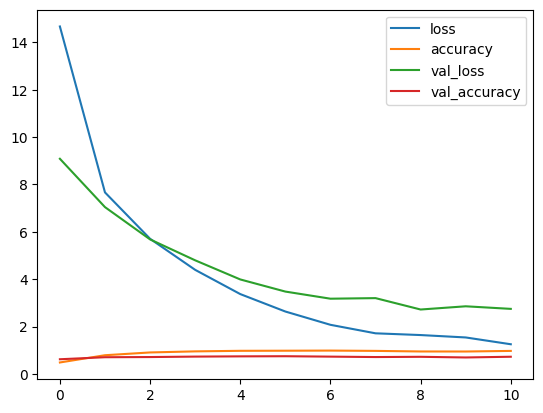

In [22]:
vgg_losses_model.plot()

In [13]:
vgg_pred = fine_tuned_vgg_model.predict(X_test)
vgg_post =np.where(vgg_pred >= 0.5, 1,0)

22/22 [==============================] - 3s 124ms/step


In [14]:
#classification_report for resnet model
print(classification_report(y_test, vgg_post))

              precision    recall  f1-score   support

           0       0.96      0.45      0.61       122
           1       0.73      0.77      0.75       157
           2       0.76      0.36      0.49        94
           3       0.86      0.77      0.81        82
           4       0.77      0.67      0.72       128
           5       0.61      0.86      0.71       104

   micro avg       0.75      0.65      0.70       687
   macro avg       0.78      0.65      0.68       687
weighted avg       0.78      0.65      0.69       687
 samples avg       0.65      0.65      0.65       687



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

test_image_path2 = "/kaggle/input/finaltest/1.jpeg"

# Load and preprocess the image
img = image.load_img(test_image_path2, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make a prediction
predictions = fine_tuned_vgg_model.predict(img_array)

num_classes = 6
predicted_class_index = np.argmax(predictions)
predicted_class_label = label_to_site[predicted_class_index]

print(f"Predicted Class: {predicted_class_label}")


1/1 [==============================] - 0s 20ms/step
Predicted Class: Roman_amphitheater


In [42]:
fine_tuned_vgg_model.save('Final_VGG_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
